<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-19 01:11:54--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-05-19 01:11:55 (219 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('/content/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

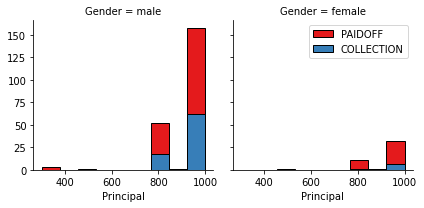

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

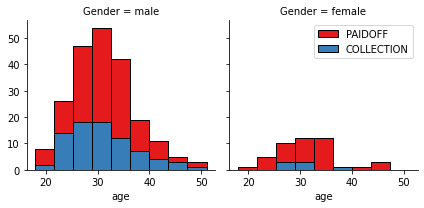

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


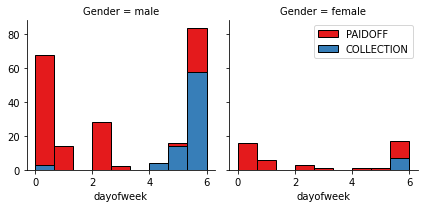

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


In [20]:
#import model selection and metrics from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
#split X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
#import libraries
from sklearn.neighbors import KNeighborsClassifier

In [22]:
#create the model
knn = KNeighborsClassifier(n_neighbors=3)

In [23]:
#select the parameters of the model
param_knn = {'n_neighbors':np.arange(1, 10),
              'weights': ['uniform', 'distance'], 
              'leaf_size':[1,3,5,7,10],
              'algorithm':['auto', 'kd_tree']}
#make a grid search
knn_grid = GridSearchCV(knn, param_grid=param_knn, scoring='accuracy', cv=5)
#fit the model
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5, 7, 10],
                         'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [24]:
#check the best params
knn_grid.best_params_

{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 5, 'weights': 'uniform'}

In [25]:
#check the score
knn_grid.score(X_train, y_train)

0.8115942028985508

In [26]:
#use the best params and fit again the model
knn_opt = KNeighborsClassifier(n_neighbors=5,
                               algorithm="auto",
                               leaf_size=3,
                               weights="uniform")
knn_opt.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=3)

In [27]:
#check the accuracy
pred_knn = knn_opt.predict(X_test)
print("Accuracy for KNN on test data: ", accuracy_score(y_test,pred_knn))

Accuracy for KNN on test data:  0.7857142857142857


In [28]:
#check the general metrics
print("the classification report:","\n",classification_report(y_test,pred_knn))

the classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.43      0.21      0.29        14
     PAIDOFF       0.83      0.93      0.87        56

    accuracy                           0.79        70
   macro avg       0.63      0.57      0.58        70
weighted avg       0.75      0.79      0.76        70



# Decision Tree


In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
tree = DecisionTreeClassifier(random_state=2)

In [31]:
param_tree = {'criterion':['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'], 
              'max_depth':np.arange(1,100),
              'min_samples_split':[2,4,8,16],
              'max_features':['sqrt',None]}

In [32]:
tree_grid = GridSearchCV(tree,
                         param_grid=param_tree,
                         scoring='accuracy',
                         cv=5)
tree_grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7920 fits failed out of a total of 23760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7920 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_fail

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'max_features': ['sqrt', None],
                         'min_samples_split': [2, 4, 8, 16],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [33]:
tree_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'splitter': 'random'}

In [34]:
tree_grid.score(X_train, y_train)

0.7789855072463768

In [35]:
#use the best params and fit again the model
tree_opt = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  max_features='sqrt',
                                  min_samples_split=2,
                                  splitter='random')
tree_opt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       splitter='random')

In [36]:
#check the accuracy
pred_tree = tree_opt.predict(X_test)
print("Accuracy for Tree on test data: ", accuracy_score(y_test,pred_tree))
#check the general metrics
print("the classification report:","\n",classification_report(y_test,pred_tree))

Accuracy for Tree on test data:  0.6571428571428571
the classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.22      0.29      0.25        14
     PAIDOFF       0.81      0.75      0.78        56

    accuracy                           0.66        70
   macro avg       0.51      0.52      0.51        70
weighted avg       0.69      0.66      0.67        70



# Support Vector Machine


In [37]:
from sklearn import svm

In [38]:
Svm = svm.SVC()

In [39]:
#select the parameters of the model
param_svm = {'kernel':['linear', 'poly','rbf', 'sigmoid'],
              'gamma':['scale', 'auto']
              }
#make a grid search
svm_grid = GridSearchCV(Svm, param_grid=param_svm, scoring='accuracy', cv=5)
#fit the model
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [40]:
#check the best params
svm_grid.best_params_

{'gamma': 'scale', 'kernel': 'linear'}

In [41]:
#check the score
svm_grid.score(X_train, y_train)

0.7644927536231884

In [42]:
#use the best params and fit again the model
svm_opt = svm.SVC(gamma='scale',kernel='linear')
svm_opt.fit(X_train, y_train)

SVC(kernel='linear')

In [43]:
#check the accuracy
pred_svm = svm_opt.predict(X_test)
print("Accuracy for SVM on test data: ", accuracy_score(y_test,pred_svm))
#check the general metrics
print("the classification report:","\n",classification_report(y_test,pred_svm))

Accuracy for SVM on test data:  0.6714285714285714
the classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.20      0.21      0.21        14
     PAIDOFF       0.80      0.79      0.79        56

    accuracy                           0.67        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.68      0.67      0.68        70



# Logistic Regression


In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
lr = LogisticRegression(random_state=0)

In [46]:
#select the parameters of the model
param_lr = {'penalty':['l2', 'none'],
              'max_iter':np.arange(100,1000,10),
              }
#make a grid search
lr_grid = GridSearchCV(lr, param_grid=param_lr, scoring='accuracy', cv=5)
#fit the model
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'max_iter': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]),
                         'penalty': ['l2', 'none']},
             scoring='accuracy')

In [47]:
#check the best params
lr_grid.best_params_

{'max_iter': 100, 'penalty': 'l2'}

In [48]:
#check the score
lr_grid.score(X_train, y_train)

0.7608695652173914

In [49]:
lr_opt = LogisticRegression(max_iter= 100, penalty= 'l2')
lr_opt.fit(X_train, y_train)

LogisticRegression()

In [50]:
#check the accuracy
pred_lr = lr_opt.predict(X_test)
print("Accuracy for LR on test data: ", accuracy_score(y_test,pred_lr))
#check the general metrics
print("the classification report:","\n",classification_report(y_test,pred_lr))

Accuracy for LR on test data:  0.7
the classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.23      0.21      0.22        14
     PAIDOFF       0.81      0.82      0.81        56

    accuracy                           0.70        70
   macro avg       0.52      0.52      0.52        70
weighted avg       0.69      0.70      0.70        70



# Model Evaluation using Test set


In [51]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [52]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-19 01:13:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-19 01:13:06 (482 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [53]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [54]:
#preprocessing
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])


In [55]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

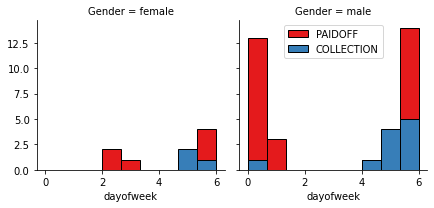

In [56]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [57]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [58]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [59]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [60]:
X = Feature

In [61]:
y = test_df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [62]:
X= preprocessing.StandardScaler().fit(X).transform(X)

In [63]:
lr_pred = lr_opt.predict(X)
lr_pred_pro_log = lr_opt.predict_log_proba(X)
svm_pred = svm_opt.predict(X)
tree_pred = tree_opt.predict(X)
knn_pred = knn_opt.predict(X)


In [64]:
log_loss(y,lr_pred_pro_log)

0.6931471805599455

In [65]:
lr_pred_pro_log.dtype

dtype('float64')

In [66]:
def score_of_models(y, model_pred, log_pred = 'Nan'):
  models = []
  models.append(("The jaccard score of the model is: ", jaccard_score(y, model_pred,pos_label='PAIDOFF')))
  models.append(("The F1 score of the model is: ", f1_score(y, model_pred,pos_label='PAIDOFF')))
  if log_pred != 'Nan':
    models.append(("the logarith loss of the model is: ", log_loss(y, log_pred)))
  else:
    models.append(("the logarith loss of the model is: ", 'Nan'))

  return models


* K Nearest Neighbor(KNN)
* Decision Tree
* Support Vector Machine
* Logistic Regression

In [67]:
#K Nearest Neighbor(KNN)
score_of_models(y,knn_pred)

[('The jaccard score of the model is: ', 0.6923076923076923),
 ('The F1 score of the model is: ', 0.8181818181818182),
 ('the logarith loss of the model is: ', 'Nan')]

In [68]:
#Decision Tree
score_of_models(y,tree_pred)

[('The jaccard score of the model is: ', 0.782608695652174),
 ('The F1 score of the model is: ', 0.8780487804878048),
 ('the logarith loss of the model is: ', 'Nan')]

In [69]:
#Support Vector Machine
score_of_models(y,svm_pred)

[('The jaccard score of the model is: ', 0.75),
 ('The F1 score of the model is: ', 0.8571428571428572),
 ('the logarith loss of the model is: ', 'Nan')]

In [70]:
#Logistic Regression
score_of_models(y,lr_pred,lr_pred_pro_log)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


[('The jaccard score of the model is: ', 0.76),
 ('The F1 score of the model is: ', 0.8636363636363635),
 ('the logarith loss of the model is: ', 0.6931471805599455)]

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.69       | 0.81       | NA      |
| Decision Tree      | 0.78       | 0.87       | NA      |
| SVM                | 0.75       | 0.85       | NA      |
| LogisticRegression | 0.76       | 0.86       | 0.69    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
